## Setup

In [38]:
#!pip install -q git+https://github.com/geopandas/dask-geopandas

import warnings
import time
import os
import gc
import re

import numpy as np

import torch
from torch.utils.data import DataLoader

import geopandas
import dask_geopandas
from dask.distributed import Client

In [ ]:
from custom import mosaiks_points
from custom.mpc_imagery import query, CustomDataset, match_images_and_points
from custom.models import featurize, RCF

In [2]:
warnings.filterwarnings(action="ignore", category=UserWarning, module="torch")
warnings.filterwarnings(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", category=RuntimeWarning)
warnings.filterwarnings(action="ignore", category=UserWarning)

In [3]:
RASTERIO_BEST_PRACTICES = dict(  # See https://github.com/pangeo-data/cog-best-practices
    CURL_CA_BUNDLE="/etc/ssl/certs/ca-certificates.crt",
    GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
    AWS_NO_SIGN_REQUEST="YES",
    GDAL_MAX_RAW_BLOCK_CACHE_SIZE="200000000",
    GDAL_SWATH_SIZE="200000000",
    VSI_CURL_CACHE_SIZE="200000000",
)
os.environ.update(RASTERIO_BEST_PRACTICES)

## Set parameters

In [4]:
num_features = 1024

In [ ]:
## TEMP: Parameters for CustomDataset
satellite = "landsat-8-c2-l2"
bands = [
    # "SR_B1", # Coastal/Aerosol Band (B1)
    "SR_B2", # Blue Band (B2)
    "SR_B3", # Green Band (B3)
    "SR_B4", # Red Band (B4)
    "SR_B5", # Near Infrared Band 0.8 (B5)
    "SR_B6", # Short-wave Infrared Band 1.6 (B6)
    "SR_B7" # Short-wave Infrared Band 2.2 (B7)
]

resolution = 30
min_image_edge = 6

In [6]:
channels = len(bands)
dat_re = re.compile(r'\d+') 
l = [str(int(dat_re.search(x).group())) for x in bands if dat_re.search(x)]
bands_short = '-'.join(l)

## Create grid and sample points to featurize
This section will be merged with the section in the modelling pipeline that serves the same purpose.

In [7]:
data_dir = "/home/jovyan/mosaiks-poc/data"

In [8]:
states = geopandas.read_file(f"{data_dir}/geometries_shrug-v1.5.samosa-open-polygons-shp/state.shp")

In [9]:
# states['zero_column'] = 0
# country = states.dissolve(by='zero_column')

<AxesSubplot:>

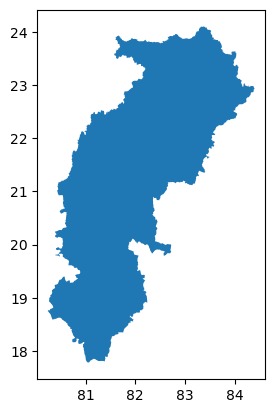

In [10]:
state_shape = states[states["s_name"] == "Chhattisgarh"]
state_shape.plot()

In [12]:
# step = 0.01
points_gdf = mosaiks_points.create_gdf_of_enclosed_points(state_shape, step=0.1, pre_calc_bounds=None)

points_gdf['lon'], points_gdf['lat'] = points_gdf.geometry.x, points_gdf.geometry.y
points_gdf = points_gdf[['lon', 'lat', 'geometry']].reset_index(drop = True)

Number of point coords in grid: 2688
Number of point coords selected: 1177


In [13]:
# temp
points_gdf = points_gdf.sample(10, random_state=0)

In [14]:
# This buffer ensures that no points are take at the border
# which would lead to duplication with neighboring countries
points_gdf = points_gdf[points_gdf.within(state_shape.unary_union.buffer(-0.005))]

In [15]:
points_gdf = mosaiks_points.sort_by_hilbert_distance(points_gdf)

In [16]:
# points_gdf.plot()

## Get the imagery around each point

In [26]:
NPARTITIONS = 250
points_dgdf = dask_geopandas.from_geopandas(points_gdf, npartitions=NPARTITIONS, sort=False)

# del points_gdf
gc.collect()

3917

In [27]:
with Client(n_workers=16) as client:
    print(client.dashboard_link)
    meta = points_dgdf._meta.assign(stac_item=[])
    points_gdf_with_stac = points_dgdf.map_partitions(query, meta=meta).compute()

/user/amirali1376@gmail.com/proxy/8787/status


In [28]:
matched_image_items, matched_points_list = match_images_and_points(points_gdf_with_stac)

In [29]:
dataset = CustomDataset(matched_points_list, matched_image_items)

In [30]:
dataloader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=os.cpu_count()*2,
    collate_fn=lambda x: x,
    pin_memory=False,
    # persistent_workers=True,
)

In [33]:
# for images in dataloader:
#     for image in images:
#         array = np.array(image[0][:3])
#         reshaped_array = np.swapaxes(array, 0, 2)
#         # print(reshaped_array)
#         plt.imshow(reshaped_array)
#         plt.show()

## Define featurization model and apply to images

First we define the pytorch model that we will use to extract the features and a helper method. The **MOSAIKS** methodology describes several ways to do this and we use the simplest.

Next, we initialize the model and pytorch components

In [50]:
DEVICE = torch.device("cuda")
MODEL = RCF(num_features).eval().to(DEVICE)

### Apply featurization to images

In [51]:
num_points = len(matched_points_list)
x_all = np.zeros((num_points, num_features), dtype=float)

tic = time.time()
i = 0
for images in dataloader:
    for image in images:

        if image is not None:
            # A full image should be ~101x101 pixels (i.e. ~1km^2 at a 10m/px spatial
            # resolution), however we can receive smaller images if an input point
            # happens to be at the edge of a S2 scene (a literal edge case). To deal
            # with these (edge) cases we crudely drop all images where the spatial
            # dimensions aren't both greater than 20 pixels.
            # condition: image.shape[1] >= 20 and image.shape[2] >= 20
            if True: # temp True
                mosaiks_features = featurize(image, MODEL, DEVICE)
                x_all[i] = mosaiks_features
            else:
                # this happens if the point is close to the edge of a scene
                # (one or both of the spatial dimensions of the image are very small)
                pass
        else:
            pass  # this happens if we do not find a S2 scene for some point

        # if i % 100 == 0:
        print(
            f"{i}/{num_points} -- {i / num_points * 100:0.2f}%"
            + f" -- {time.time()-tic:0.2f} seconds"
        )
        tic = time.time()
        i += 1

0/10 -- 0.00% -- 2.69 seconds
1/10 -- 10.00% -- 0.00 seconds
2/10 -- 20.00% -- 0.00 seconds
3/10 -- 30.00% -- 0.00 seconds
4/10 -- 40.00% -- 0.00 seconds
5/10 -- 50.00% -- 0.00 seconds
6/10 -- 60.00% -- 0.00 seconds
7/10 -- 70.00% -- 0.00 seconds
8/10 -- 80.00% -- 0.00 seconds
9/10 -- 90.00% -- 0.00 seconds


In [52]:
x_all

array([[1.51303813e-01, 0.00000000e+00, 8.42119679e-02, ...,
        6.42196596e-01, 2.49952865e+00, 8.27894211e-02],
       [1.28017497e+00, 0.00000000e+00, 6.56100035e-01, ...,
        4.12465960e-01, 4.14854097e+00, 1.37890242e-02],
       [5.33856750e-01, 1.52935844e-03, 3.25741917e-01, ...,
        5.76654077e-01, 3.18631244e+00, 2.56237276e-02],
       ...,
       [2.34843060e-01, 0.00000000e+00, 1.11207932e-01, ...,
        2.16003418e-01, 2.64549065e+00, 5.09575494e-02],
       [6.97549760e-01, 8.85273367e-02, 2.61654228e-01, ...,
        3.21363509e-01, 2.83622456e+00, 5.35845011e-02],
       [9.65939760e-01, 9.89024341e-03, 4.49844688e-01, ...,
        5.49686193e-01, 3.77117014e+00, 9.26913042e-03]])

In [53]:
np.savetxt("x_all.csv", x_all, delimiter=",")